In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from ucimlrepo import fetch_ucirepo
import kdm
from kdm.utils import dm_rbf_expectation, dm_rbf_variance, dm_rbf_loglik

In [7]:
# Load the dataset
concrete_compressive_strength = fetch_ucirepo(id=165)
X = concrete_compressive_strength.data.features
y = concrete_compressive_strength.data.targets

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

# Scale the target to a reasonable range
scaler_y = MinMaxScaler((0.2, 0.8))
y_train = scaler_y.fit_transform(y_train)
y_test = np.asarray(y_test).reshape(-1)

# Convert to numpy arrays and ensure correct shapes
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).reshape(-1, 1).astype('float32')  # Resha


In [10]:
def train_kdm_model(n_comp=32, generative=False, epochs=200):
    """
    Train KDM model with random initialization
    """
    # Define model dimensions
    encoded_size = X_train.shape[1]
    dim_y = 1
    
    # Simple identity encoder since we're using the standardized features directly
    encoder = keras.Sequential([keras.layers.Identity()])

    # Create KDM regression model
    kdm_reg_model = kdm.models.KDMRegressModel(
        encoded_size=encoded_size,
        dim_y=dim_y,
        encoder=encoder,
        n_comp=n_comp,
        sigma_x=0.1,
        sigma_y=0.1,
        generative=generative
    )

    # Compile the model
    kdm_reg_model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-3),
        loss=None
    )

    # Initialize components with random samples
    idx = np.random.randint(X_train.shape[0], size=n_comp)
    selected_X = X_train[idx]
    selected_y = y_train[idx]
    
    # Initialize components
    kdm_reg_model.init_components(
        selected_X,
        selected_y,
        init_sigma=True
    )

    # Train the model
    losses = []
    sigma_x = []
    sigma_y = []
    
    for i in range(epochs):
        history = kdm_reg_model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        losses.append(history.history['loss'][0])
        sigma_x.append(keras.ops.convert_to_numpy(kdm_reg_model.kernel.sigma))
        sigma_y.append(keras.ops.convert_to_numpy(kdm_reg_model.sigma_y))

    # Plot training metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(losses)
    plt.title("Loss")
    
    plt.subplot(1, 3, 2)
    plt.plot(sigma_x)
    plt.title("Sigma X")
    
    plt.subplot(1, 3, 3)
    plt.plot(sigma_y)
    plt.title("Sigma Y")
    
    plt.tight_layout()
    plt.show()
    
    return kdm_reg_model

In [13]:
def evaluate_kdm_model(kdm_model, X_test, y_test, model_name="KDM"):
    # Make predictions
    rho_y = kdm_model.predict(X_test)
    y_pred = keras.ops.convert_to_numpy(dm_rbf_expectation(rho_y)).flatten()
    y_var = keras.ops.convert_to_numpy(dm_rbf_variance(rho_y, kdm_model.sigma_y))
    
    # Scale predictions back to original range
    y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Test MSE: {mse:.4f}")
    print(f"{model_name} Test MAE: {mae:.4f}")
    print(f"{model_name} Test R²: {r2:.4f}")
    
    # Plot predictions vs actual with uncertainty
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
    
    # Add error bars for some points (every 10th point to avoid cluttering)
    indices = np.arange(0, len(y_test), 10)
    plt.errorbar(y_test[indices], y_pred[indices], 
                yerr=1.96 * np.sqrt(y_var[indices]), 
                fmt='none', alpha=0.2, color='blue', label='95% confidence interval')
    
    plt.xlabel("Actual Strength")
    plt.ylabel("Predicted Strength")
    plt.title(f"{model_name} Predicted vs Actual Concrete Compressive Strength")
    plt.legend()
    plt.show()
    
    return y_pred, y_var


In [14]:
print("Training Gaussian Process model...")
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10., (1e-2, 1e2))
gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.01,
    n_restarts_optimizer=10
)

Training Gaussian Process model...


In [15]:
gp.fit(X_train, y_train.ravel())
gp_pred, gp_sigma = gp.predict(X_test, return_std=True)
gp_pred = scaler_y.inverse_transform(gp_pred.reshape(-1, 1)).flatten()

In [16]:
print(f"GP Test MSE: {mean_squared_error(y_test, gp_pred):.4f}")
print(f"GP Test MAE: {mean_absolute_error(y_test, gp_pred):.4f}")
print(f"GP Test R²: {r2_score(y_test, gp_pred):.4f}")

GP Test MSE: 59.1304
GP Test MAE: 6.0567
GP Test R²: 0.7815



Training discriminative KDM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


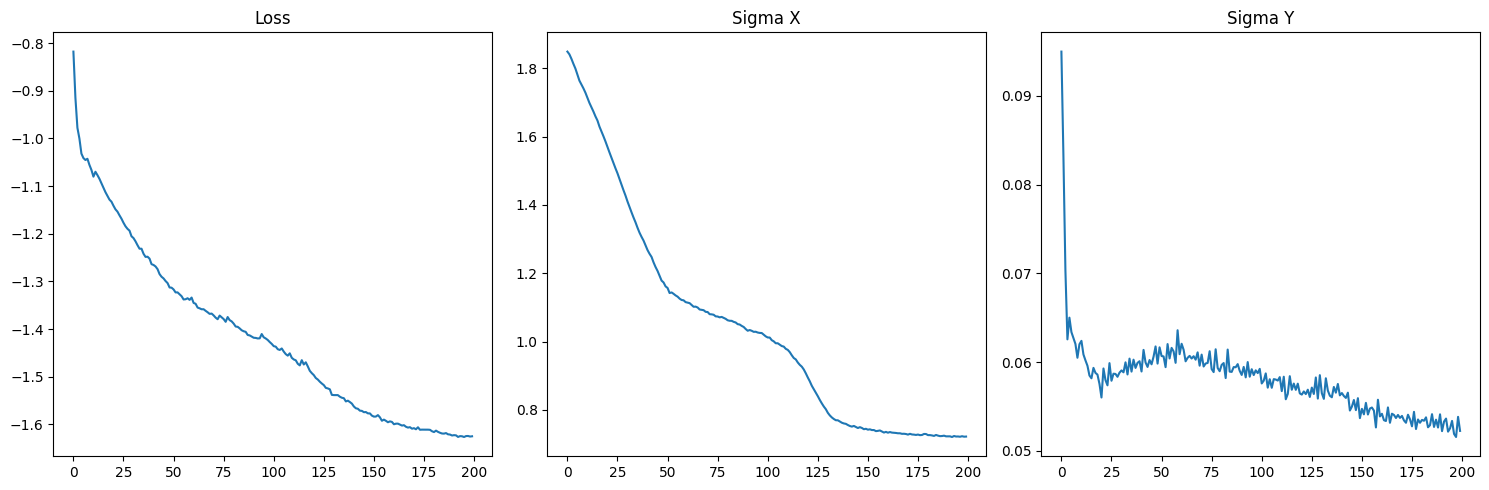

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
KDM Discriminative Test MSE: 71.3925
KDM Discriminative Test MAE: 6.5237
KDM Discriminative Test R²: 0.7361


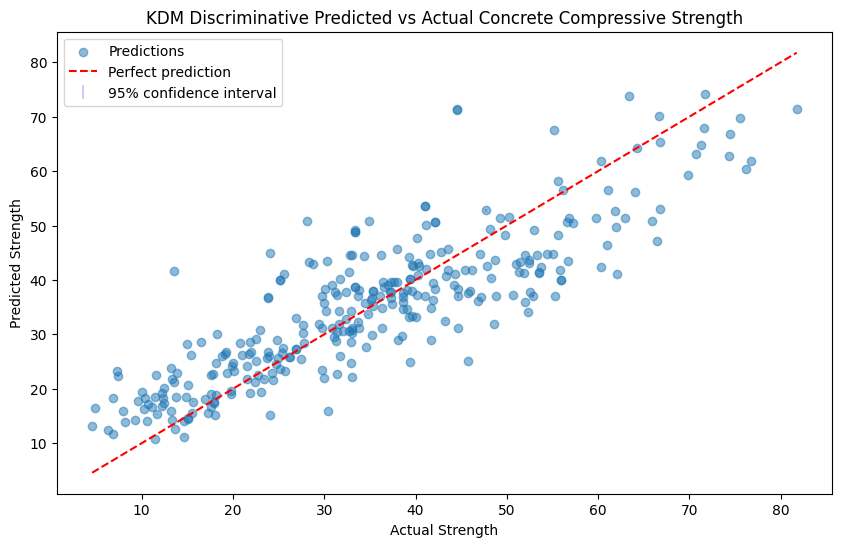

In [17]:
print("\nTraining discriminative KDM model...")
kdm_disc = train_kdm_model(n_comp=32, generative=False, epochs=200)
y_pred_disc, var_disc = evaluate_kdm_model(kdm_disc, X_test, y_test, "KDM Discriminative")


Training generative KDM model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


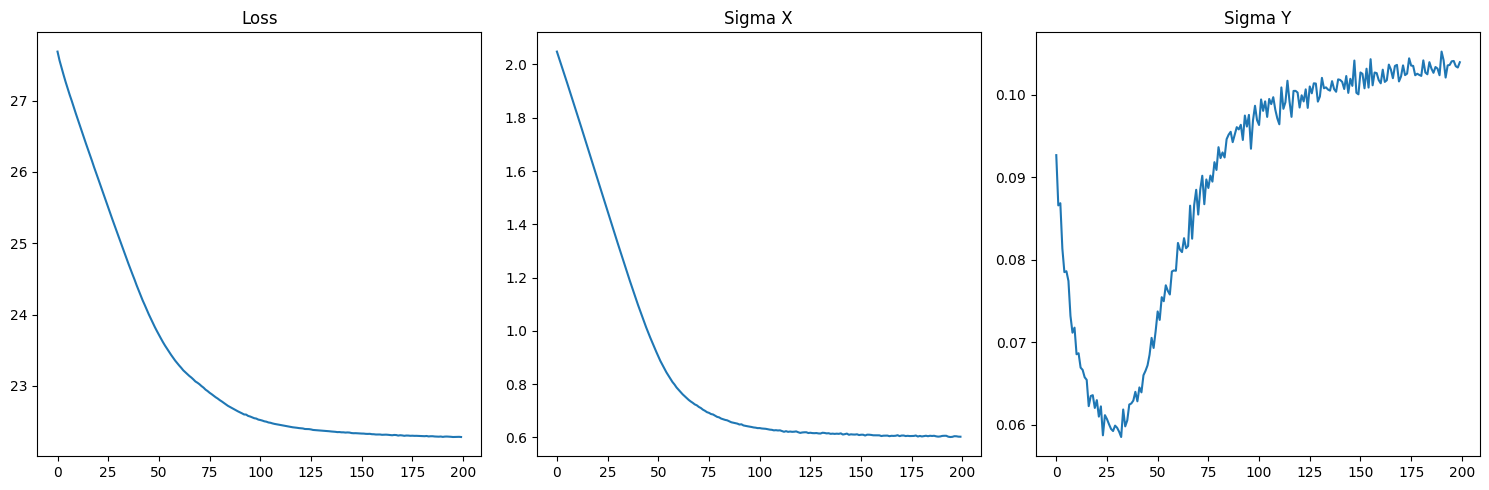

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
KDM Generative Test MSE: 161.0632
KDM Generative Test MAE: 9.9602
KDM Generative Test R²: 0.4047


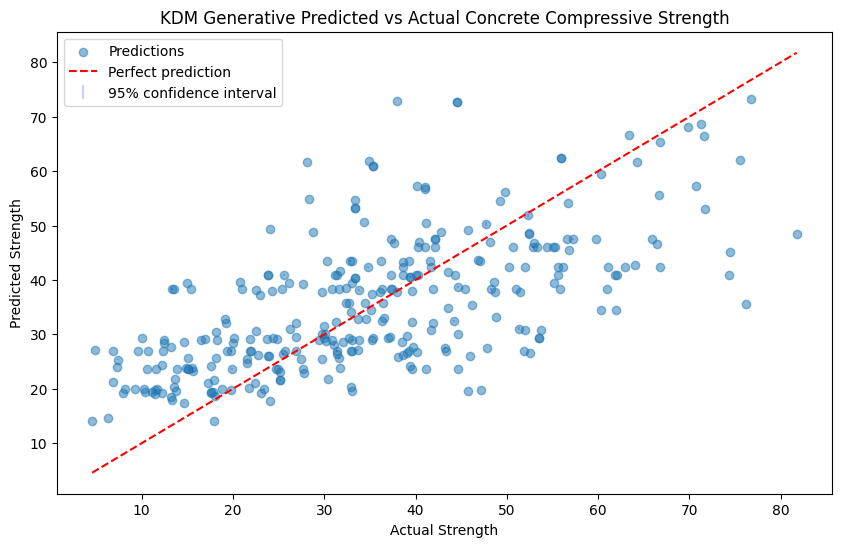

In [18]:
print("\nTraining generative KDM model...")
kdm_gen = train_kdm_model(n_comp=32, generative=True, epochs=200)
y_pred_gen, var_gen = evaluate_kdm_model(kdm_gen, X_test, y_test, "KDM Generative")

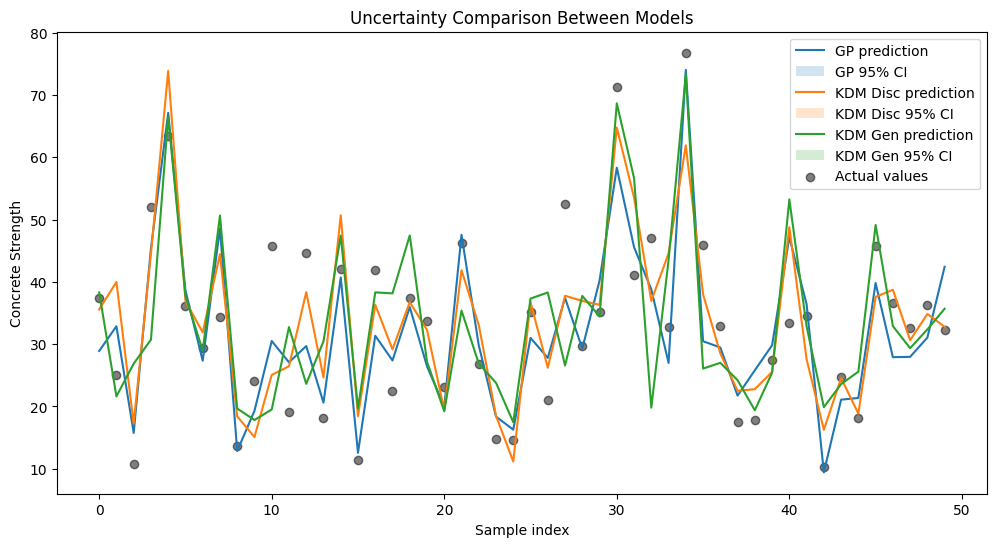

In [19]:
def plot_uncertainty_comparison(x_subset, y_test, models_dict):
    plt.figure(figsize=(12, 6))
    
    for name, (pred, std) in models_dict.items():
        plt.plot(x_subset, pred, label=f'{name} prediction')
        plt.fill_between(x_subset, 
                        pred - 1.96 * std,
                        pred + 1.96 * std,
                        alpha=0.2, label=f'{name} 95% CI')
    
    plt.scatter(x_subset, y_test, color='black', alpha=0.5, label='Actual values')
    plt.xlabel('Sample index')
    plt.ylabel('Concrete Strength')
    plt.title('Uncertainty Comparison Between Models')
    plt.legend()
    plt.show()

# Plot uncertainty comparison for a subset of test points
subset_size = 50
subset_indices = np.sort(np.random.choice(len(X_test), subset_size, replace=False))
x_subset = np.arange(subset_size)

models_dict = {
    'GP': (gp_pred[subset_indices], gp_sigma[subset_indices]),
    'KDM Disc': (y_pred_disc[subset_indices], np.sqrt(var_disc[subset_indices])),
    'KDM Gen': (y_pred_gen[subset_indices], np.sqrt(var_gen[subset_indices]))
}

plot_uncertainty_comparison(x_subset, y_test[subset_indices], models_dict)